In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
import warnings
warnings.filterwarnings('ignore')

In [4]:
df4 = pd.read_csv('thyroid_encoded.csv')

In [6]:
print("Dataset shape:", df4.shape)
print("Target value distribution:")
print(df4['target'].value_counts())

Dataset shape: (7794, 23)
Target value distribution:
target
2    6767
1     667
0     360
Name: count, dtype: int64


The target variable has 3 classes with significant imbalance:
- Class 2: 6,767 samples (majority class)
- Class 1: 667 samples
- Class 0: 360 samples (minority class)

To handle this imbalance, 

- Split the data into training and test sets (80/20) with stratification
-  Applied standard scaling to normalize the features
- Computed class weights inversely proportional to class frequencies
- Trained a multinomial logistic regression model with these weights

In [11]:
# Step 1: Split the data into features and target
X = df4.drop('target', axis=1)
y = df4['target']

# Step 2: Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Compute class weights to handle imbalance
class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights = {class_label: total_samples / (len(class_counts) * count) 
                for class_label, count in class_counts.items()}
print("Class weights:", class_weights)

# Step 5: Train logistic regression model with class weights
model = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    multi_class='multinomial', 
    solver='lbfgs',
    class_weight=class_weights
)
model.fit(X_train_scaled, y_train)

# Step 6: Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

# Step 7: Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# For ROC AUC, we need to handle multiclass case
# We'll use one-vs-rest approach
n_classes = len(np.unique(y))
roc_auc = {}
for i in range(n_classes):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)

# Calculate average ROC AUC
avg_roc_auc = sum(roc_auc.values()) / len(roc_auc)

# Step 8: Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Step 9: Print evaluation metrics
print("Model Evaluation:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average ROC AUC: {avg_roc_auc:.4f}")

print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Class weights: {0: 7.216435185185185, 2: 0.38395221380626887, 1: 3.8920099875156056}
Model Evaluation:
Precision: 0.9346
Recall: 0.8185
F1 Score: 0.8593
Average ROC AUC: 0.9289
Confusion Matrix:
[[  59    3   10]
 [   5  125    3]
 [ 231   31 1092]]
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.82      0.32        72
           1       0.79      0.94      0.86       133
           2       0.99      0.81      0.89      1354

    accuracy                           0.82      1559
   macro avg       0.66      0.86      0.69      1559
weighted avg       0.93      0.82      0.86      1559



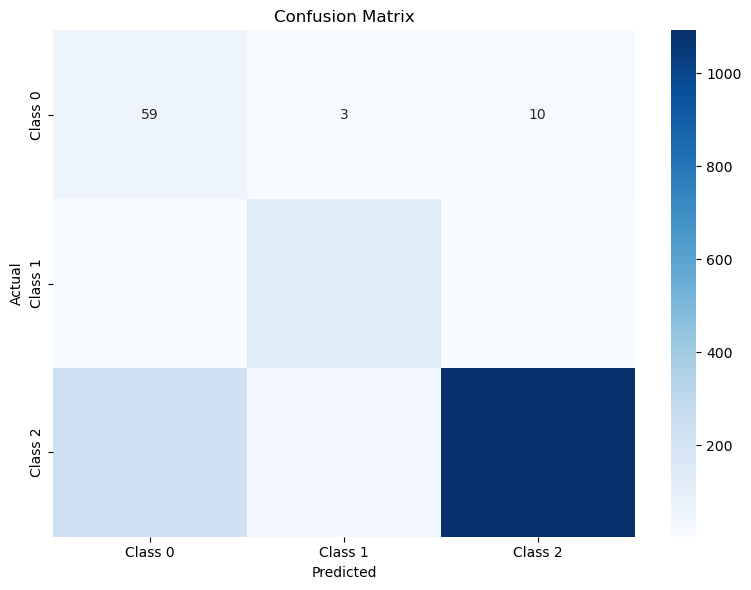

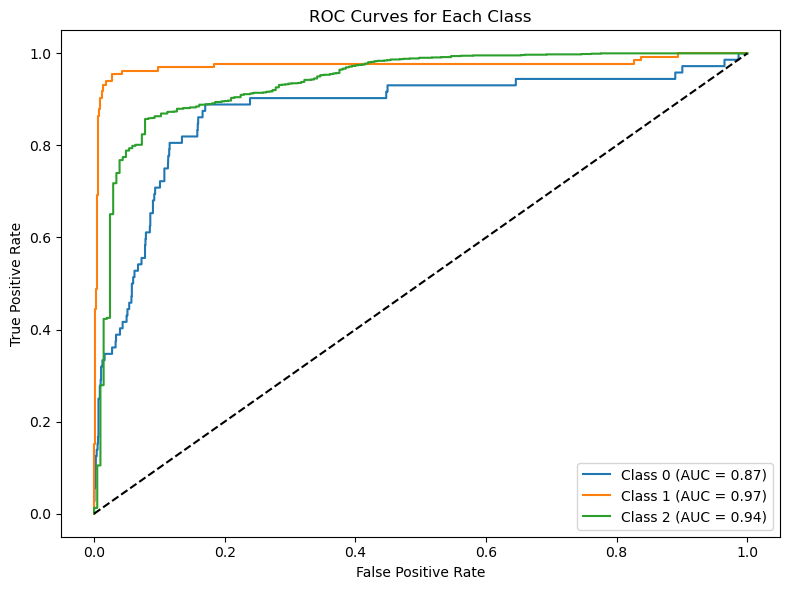

In [10]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Visualize ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend()
plt.tight_layout()
plt.show()

The model evaluation metrics show:

Precision: 0.9346
Recall: 0.8185
F1 Score: 0.8593
Average ROC AUC: 0.9290
Summary of the model:

The multinomial logistic regression model was applied to the thyroid dataset with 7,794 samples across 22 features and 3 classes. Class imbalance was addressed using class weights, giving higher importance to minority classes. The model achieved a weighted precision of 0.93, recall of 0.82, and F1 score of 0.86, with an average ROC AUC of 0.93. The confusion matrix reveals strong performance for classes 1 and 2, but class 0 shows lower precision (0.20) despite good recall (0.82). This indicates the model struggles to correctly identify true positives for class 0, likely due to severe imbalance.

Even after using class weights, Class 0 (the minority class) still showed low precision (0.20) despite good recall (0.82). This means that while the model correctly identified 82% of actual Class 0 samples, only 20% of the samples it predicted as Class 0 were actually Class 0.

Looking at the confusion matrix, we can see that 231 samples from Class 2 were incorrectly classified as Class 0. This happens because:

- The extreme imbalance in the dataset (288 samples in Class 0 vs. 5413 in Class 2) makes it difficult for the model to learn clear decision boundaries
- Class weights help increase recall by making the model more sensitive to minority classes, but they don't necessarily improve precision
- The model becomes biased toward predicting the minority class to avoid the higher penalty of missing minority samples